In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("../Notebooks"))
from helper_functions import  *
from tqdm import tqdm

In [3]:
#from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count,combinations

from statistics import mean
from scipy import stats

# Import Data

In [4]:
# Read compressed csv with built-in gzip support
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 

In [50]:
df_recipes.head()
#print(df_recipes.shape)

,name,id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


In [6]:
df_ingredients.head()
print(df_ingredients.shape)

(11659, 9)


In [7]:
df_reviews.head()
print(df_reviews.shape)

(1132367, 5)


In [8]:
# Convert to dtype and check 
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews.dtypes

user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
dtype: object

In [40]:
# Filter years 2017 + 2018 as our final subset 

df_reviews_filter = df_reviews[df_reviews['date'].dt.strftime('%Y') > '2016']
df_reviews_filter.shape

(47709, 5)

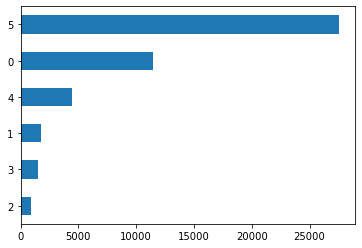

In [41]:
# Value counts for each of the rating values
df_reviews_filter.rating.value_counts().sort_values().plot(kind = 'barh')
None

In [16]:
df_reviews_filter

,user_id,recipe_id,date,rating,review
39,2002068522,29093,2018-03-26,0,i made it and it was amazing
67,2002097693,79222,2018-04-05,0,Do you have cook the potatoes beforehand?
134,2001891832,183729,2018-04-30,0,There is no cooking temp?????? Love this recip...
184,2001338551,195977,2017-04-04,0,Have made this cake often. Have added 1 1/2 c ...
192,571722,195977,2017-01-09,1,"This was incredibly sweet, and I reduced the s..."
...,...,...,...,...,...
1132315,2000431901,40514,2017-11-25,5,SO good! I ate 4 of them fresh from the oven!
1132325,2000650711,290157,2017-04-10,0,Would this make a good hamburger patty seasoning?
1132359,2001898209,82303,2018-07-05,5,This is the best and easiest hot fudge ever. I...
1132360,2002357020,82303,2018-12-05,5,Delicious quick thick chocolate sauce with ing...


# Create edges

In [11]:
recipes_user_dict={id: [] for id in df_recipes['id'].unique()}
print(len(recipes_user_dict))
recipe_error = []


for idx, row in tqdm(df_reviews_filter.iterrows()): 
    try:
        #for ingredient in row['ingredient_ids']:
        recipes_user_dict[row['recipe_id']].append(row['user_id'])
    except:
        recipe_error.append(row['recipe_id'])


# All possible pairs in List using combinations()
edges_ru = [(x,y, {"recipe_id": key})  for key in recipes_user_dict for x, y in list(combinations(recipes_user_dict[key], 2))]   


178265


47709it [00:01, 34945.06it/s]


## Create Graph

In [46]:
#!pip install networkx
import networkx as nx

G = nx.MultiDiGraph()
G.add_nodes_from(np.unique(df_reviews_filter['user_id'].values))
print(G)

G.add_edges_from(edges_ru)
print(G)



MultiDiGraph with 38250 nodes and 0 edges
MultiDiGraph with 38250 nodes and 590460 edges


In [47]:
df_graph=pd.DataFrame()

df_graph['user_id']=(np.unique(df_reviews_filter['user_id'].values))

# Graph analysis

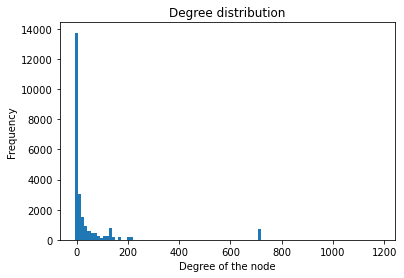

Slope of distribution: -0.9477423223385324


In [13]:

# In and out degree distributions & slope estimate(W5)
def plot_deg_dist(G, title = str):

    degree_list = [val for (node, val) in G.degree() if val != 0]

    counts, edges = np.histogram(degree_list, bins = 100)
    plt.bar(edges[:-1], counts, width=np.diff(edges))
    plt.title(title)
    plt.xlabel('Degree of the node')
    plt.ylabel('Frequency')
    plt.show()
    idx = np.isfinite(np.log(edges[:10])) & np.isfinite(np.log(counts[:10]))
    slope, intercept = np.polyfit(np.log(edges[:10])[idx], np.log(counts[:10])[idx], 1)
    print(f'Slope of distribution: {slope}')

plot_deg_dist(G, title = 'Degree distribution')  
    

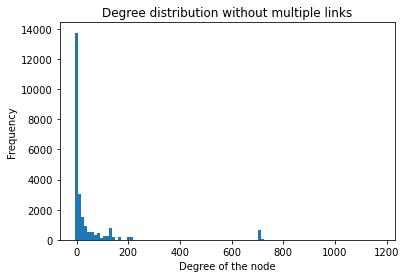

Slope of distribution: -0.9447117454222944


In [14]:
G2 = nx.Graph(G)
plot_deg_dist(G2, title = 'Degree distribution without multiple links')  

In [15]:
# Obtain largest component
largest_cc = max(nx.connected_components(G2))
GCC = G2.subgraph(largest_cc).copy()

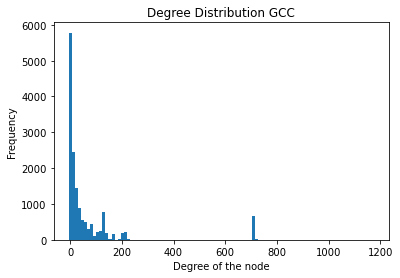

Slope of distribution: -0.7595052310486371


In [16]:
plot_deg_dist(GCC, title = 'Degree Distribution GCC')

In [17]:
degree_list = [val for (node, val) in GCC.degree()]
# Calculate stats
mean = np.mean(degree_list)
median = np.median(degree_list)
mode = stats.mode(degree_list)[0]
d_min = np.min(degree_list)
d_max = np.max(degree_list)

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 74.61309562823622
Median:21.0
Mode:[715]
Min:1
Max:1179


# Plot Graph with Force Atlas

In [30]:
def plot_graph_fa(G,iterations, edge_color, node_color, title):

    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



    # Gets positions of the nodes 
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=iterations)

    # Node size dictionary according to degrees
    d = dict(nx.degree(G))

    # Create color mapping dictionary
    #mapping = {"Marvel": 'red', "DC": 'black'}
    #colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



    # Plot the Network 
    plt.figure(3,figsize=(25,25)) 
    nc = nx.draw_networkx_nodes(G, 
                        positions, 
                        node_size=[v * 0.2 for v in d.values()], 
                        #node_size = 10,
                        label=True,  
                        node_color=node_color,
                        #cmap=plt.cm.plasma_r, 
                        )

    ec = nx.draw_networkx_edges(GCC, 
                                positions, 
                                edge_color="#ECC836", 
                                alpha=0.2)

    plt.axis('off')
    plt.title(title, size = 30)
    plt.show()

    

    return None

100%|██████████| 2000/2000 [07:05<00:00,  4.70it/s]


BarnesHut Approximation  took  184.28  seconds
Repulsion forces  took  178.24  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  48.95  seconds
AdjustSpeedAndApplyForces step  took  6.60  seconds


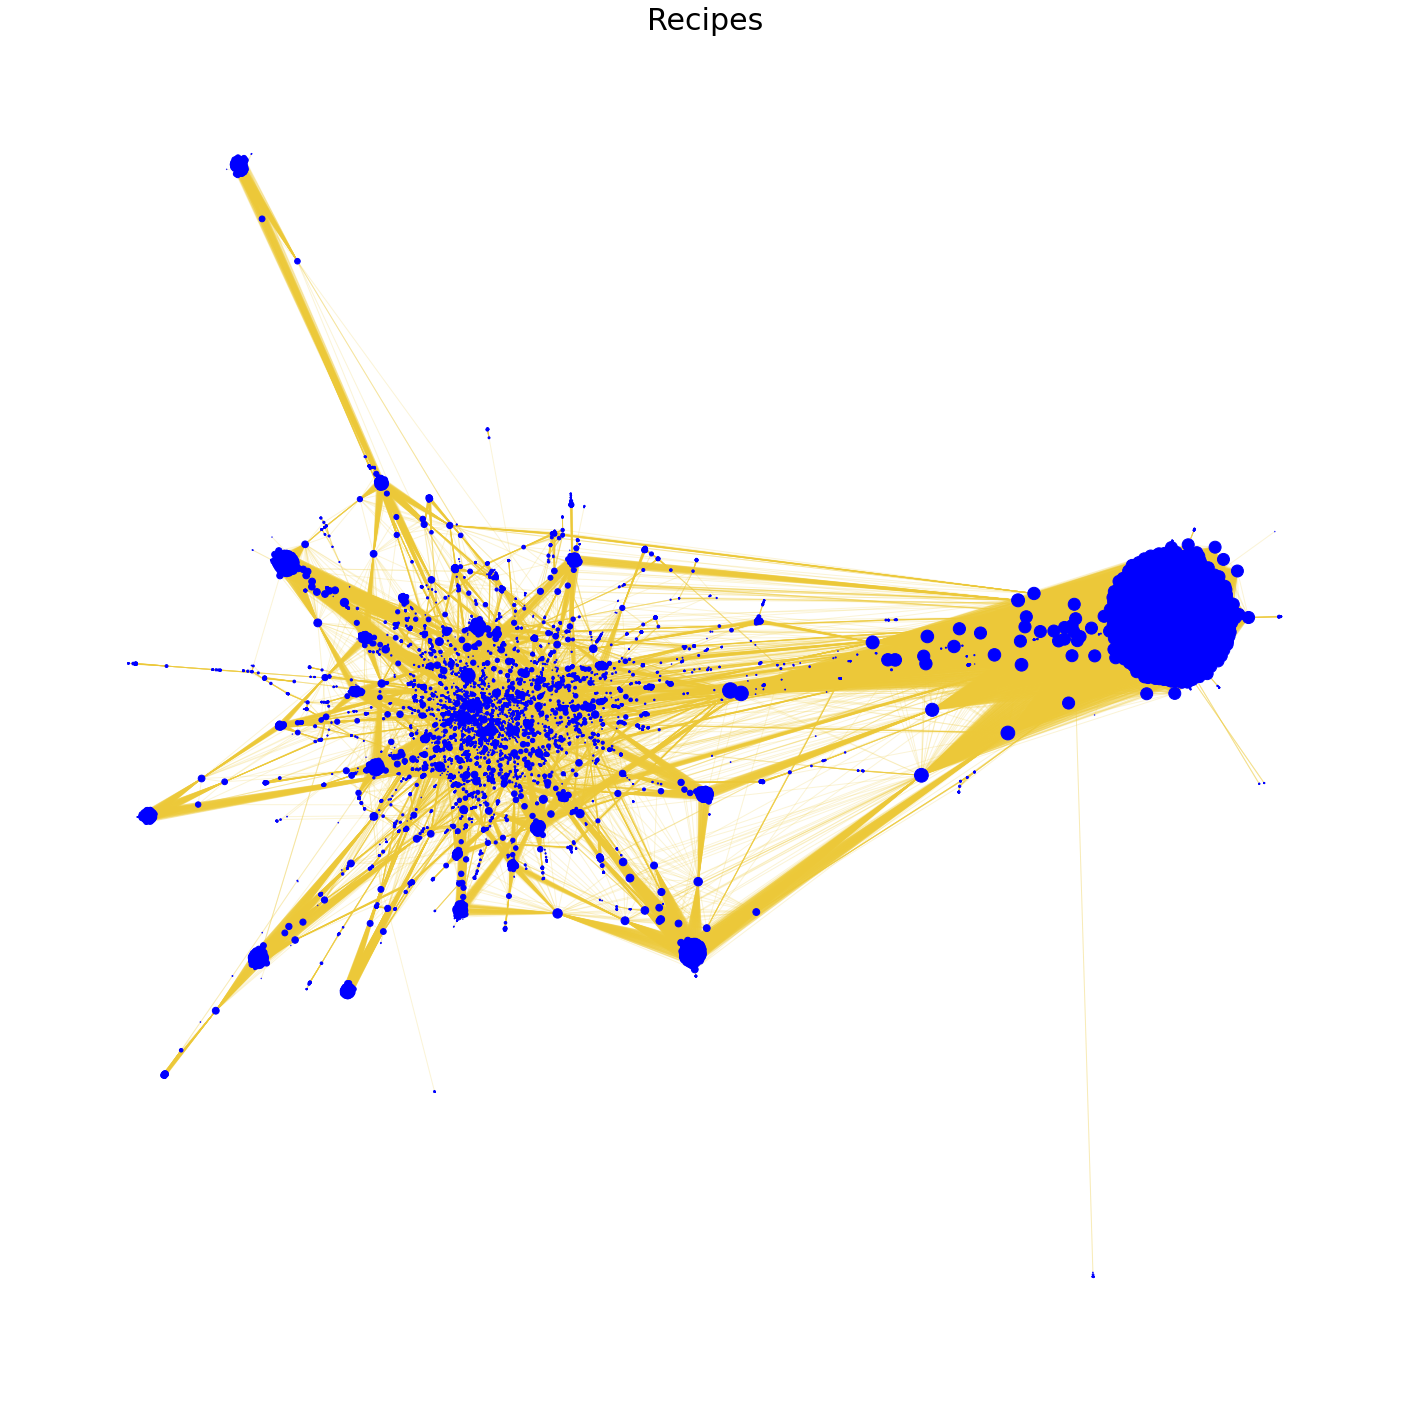

In [31]:
plot_graph_fa(GCC, iterations = 2000, edge_color="#ECC836",node_color='blue', title = 'Users')

Communities detection

In [19]:
%pip install python-louvain
import community.community_louvain as community

Note: you may need to restart the kernel to use updated packages.


In [20]:

# first compute the best partition for GCC
partition = community.best_partition(GCC)

# find modularity
M = community.modularity(partition, GCC)
print(f"Users graph modularity = {M} - found using community.modularity function")

from collections import Counter

#communities stats
count = Counter(partition.values())
print(f"Number of communities: {len(count)}")

from collections import Counter
count_size = Counter(count.values())

for key in count_size:
    print(f"{count_size[key]} communities of size {key} nodes was found")

largest_10_communities=sorted(count.items(), key=lambda item: item[1])[-10:]

Users graph modularity = 0.76047957720294 - found using community.modularity function
Number of communities: 69
2 communities of size 199 nodes was found
1 communities of size 611 nodes was found
1 communities of size 438 nodes was found
1 communities of size 392 nodes was found
1 communities of size 474 nodes was found
1 communities of size 455 nodes was found
1 communities of size 737 nodes was found
1 communities of size 217 nodes was found
1 communities of size 179 nodes was found
1 communities of size 87 nodes was found
1 communities of size 315 nodes was found
1 communities of size 268 nodes was found
2 communities of size 529 nodes was found
1 communities of size 220 nodes was found
1 communities of size 14 nodes was found
1 communities of size 751 nodes was found
1 communities of size 335 nodes was found
1 communities of size 299 nodes was found
1 communities of size 74 nodes was found
1 communities of size 252 nodes was found
1 communities of size 160 nodes was found
1 communi

In [48]:
df_graph['community'] = df_graph['user_id'].map(partition)
df_graph= df_graph.dropna

,user_id,community
0,1535,46.0
1,3288,53.0
2,4439,33.0
3,4470,33.0
4,4740,NaN
...,...,...
38245,2002371755,NaN
38246,2002371792,NaN
38247,2002371843,60.0
38248,2002372464,NaN


In [49]:
 # Take the largest 10 
largest_com = dict(df_graph['community'].value_counts().head(10))
list_largest_com = list(largest_com.keys())
print(f'The 10 largest communities are: {list_largest_com}')

The 10 biggest communities are: [33.0, 6.0, 1.0, 43.0, 29.0, 15.0, 4.0, 5.0, 36.0, 2.0]


In [56]:
#make a subgraph for community

nodes_c1=df_graph[df_graph['community']==list_largest_com [0]]['user_id']

G_C1=G.subgraph(nodes_c1)
print(G_C1)

#find 
recipies = [recipe['recipe_id'] for node1, node2, recipe in G_C1.edges(data=True)]

c1_recipies=np.unique(np.array(recipies))
len(c1_recipies)

#IN PROGRESS - Ingredients workcloudszx
ing=''.join(''.join(df_recipes[df_recipes['id'].isin(c1_recipies)].ingredients.values))
df_recipes[df_recipes['id'].isin(c1_recipies)].ingredients.value

MultiDiGraph with 751 nodes and 4156 edges


406

TypeError: sequence item 0: expected str instance, list found

<function ndarray.flatten>